In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_GPIO = 'GPIOs.csv'
file_traces = 'traces.csv'

GET TTL TIMES, TIMELINE AND ZSCORE FROM CSV FILE

In [2]:
# returns a list with TTL lengths and a list with the time of their onset
def events(file_GPIO):
    value_threshold = 5000   # which value is definitely >value_low and <value_high
    channel_name = ' GPIO-1'
    
    TTL_duration_list = []
    TTL_onset_list = []

    with open(file_GPIO, 'r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)
        val_low = True
        current_event = None
        
        for row in csv_reader:
            timestamp, current_channel, value = round(float(row[0]), 2), row[1], row[2]
            
            if current_channel == channel_name:
                value = int(value)
                # from OFF to ON state
                if val_low and value > value_threshold:
                    current_event = {'start': timestamp}     # create little dictionary
                    val_low = False
                
                # from ON to OFF state
                elif not val_low and value < value_threshold:
                    val_low = True
                    current_event['end'] = timestamp
                    duration = round(current_event['end'] - current_event['start'], 1)
                    
                    try:
                        position = TTL_duration_list.index(duration)
                        TTL_onset_list[position].append(current_event['start'])
                    except ValueError:
                        TTL_duration_list.append(duration)
                        TTL_onset_list.append([current_event['start']])
    
    return TTL_duration_list, TTL_onset_list
    
TTL_duration_list, TTL_onset_list = events(file_GPIO)

print(f'TTL_duration_list: {TTL_duration_list}')
print(f'TTL_onset_list: {TTL_onset_list}')

TTL_duration_list: [0.5, 0.1, 1.0, 1.5]
TTL_onset_list: [[61.5, 1721.35, 1911.35], [121.5, 151.5, 181.5], [130.5, 160.5, 1781.35, 1811.35, 1841.35, 1871.35, 1901.35], [190.5]]


In [29]:
# get timepoints, cell numbers, raw traces and zscores
def timeline(file_traces):
    with open(file_traces, 'r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        next(csv_reader)
        next(csv_reader)
        
        timeline = np.array([round(float(row[0]), 1) for row in csv_reader])
            
    return timeline

timeline = timeline(file_traces)

# get acc cells and traces out of the traces file
def get_traces(file_traces):
    with open(file_traces, 'r') as csvfile:
        csv_reader = csv.reader(csvfile, delimiter=',')
        everything = list(csv_reader)  # every row is now a list in a list  [[row0], [row2]]

        cells, status = everything[0], everything[1]
        transposed_traces = [list(map(float, row)) for row in zip(*everything[2:])]  # now floats and [[cell0], [cell1]]
        
        # get rid of declined cells
        acc_indices = [i for i, cell_status in enumerate(status) if cell_status == ' accepted']
        acc_cells = [cells[i] for i in acc_indices]
        traces = np.array([transposed_traces[i] for i in acc_indices])

        cells = [int(cell[2:]) for cell in acc_cells]
    
    return cells, traces

cells, traces = get_traces(file_traces)

# calculate z-score from df/f lists
zscore = np.array([(cell - np.mean(cell)) / np.std(cell) for cell in traces])

print(np.shape(zscore))
print(f'timepoints: {len(timeline)} until {timeline[-1]}')
print(f'accepted cells: {len(cells)}')
print(f'data points: {len(zscore[0])}') if all(len(lst) == len(zscore[0]) for lst in zscore) else print('!!!data points different!!!')

(390, 5778)
timepoints: 5778 until 1990.7
accepted cells: 390
data points: 5778


PANEL_A: Event-Aligned Activity Heatmap

In [414]:
# create data window
event_of_interest = 130.5
stat_window = [-1, 1]
vis_window = [-1, 2]

def window(timeline, zscore):
    # focus around event
    relative_timeline = timeline - event_of_interest
    vis_indices = np.where((relative_timeline >= vis_window[0]) & (relative_timeline <= vis_window[1]))
    vis_window_zscore = [cell[vis_indices] for cell in zscore]
    vis_window_timeline = relative_timeline[vis_indices]

    # do statistics between pre- and post-mean
    stat_indices = np.where((relative_timeline >= stat_window[0]) & (relative_timeline <= stat_window[1]))
    stat_window_timeline = relative_timeline[stat_indices]
    zero_indices = np.where(stat_window_timeline == 0.0)[0][0]
    
    stat_window_zscore = [cell[stat_indices] for cell in zscore]
    pre_mean = np.array([np.mean([cell[: zero_indices]]) for cell in stat_window_zscore])
    post_mean = np.array([np.mean([cell[zero_indices :]]) for cell in stat_window_zscore])
    means = post_mean - pre_mean

    # sort pairs upon pre- and post-difference
    sorted_pairs = sorted(zip(means, vis_window_zscore), reverse=True)
    sorted_vis_window_zscore = [cell for _, cell in sorted_pairs]

    return sorted_vis_window_zscore, vis_window_timeline

sorted_vis_window_zscore, vis_window_timeline = window(timeline, zscore)
#del sorted_vis_window_zscore[50:350]

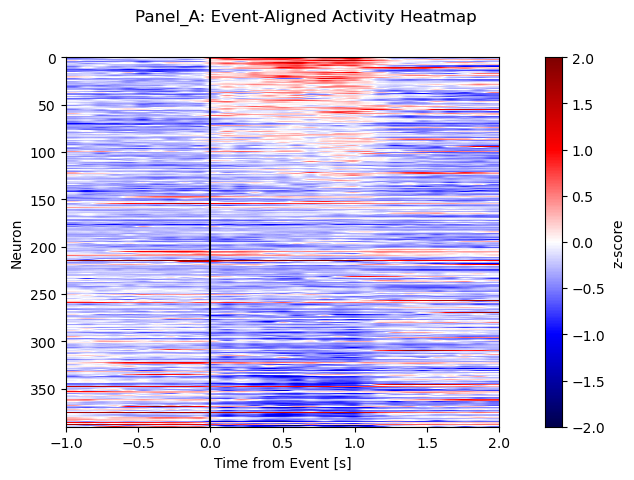

In [415]:
# draw heatmap
color_border = [-2, 2]

# scale all z-scores to 0-1
def scale_zscores(sorted_vis_window_zscore):
    scale_factor = 1/(color_border[1] - color_border[0])

    scaled_zscores = [[(i - color_border[0]) * scale_factor for i in cell] for cell in sorted_vis_window_zscore]
    scaled_zscores = np.array([[min(max(value, color_border[0]), color_border[1]) for value in cell] for cell in scaled_zscores])

    return scaled_zscores
scaled_zscores = scale_zscores(sorted_vis_window_zscore)


def plot_heatmap_and_gradient(axs, data, color_map, gradient, timeline):
    im_left = axs[0].imshow(data, cmap=color_map, aspect="auto", extent=[timeline[0], timeline[-1], data.shape[0], 0])
    axs[0].set_xlabel("Time from Event [s]")
    axs[0].set_ylabel("Neuron")
    axs[0].axvline(x=0, color="black")

    im_right = axs[1].imshow(gradient.T, cmap=color_map, aspect="auto", extent=[0, 1, color_border[0], color_border[1]])
    axs[1].set_ylabel("z-score")
    axs[1].yaxis.set_label_position("right")
    axs[1].yaxis.tick_right()
    axs[1].xaxis.set_visible(False)

    return im_left, im_right


fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [25, 1]})
fig.suptitle(f"Panel_A: Event-Aligned Activity Heatmap")
gradient = np.vstack((np.linspace(1, 0, 256), np.linspace(1, 0, 256)))

im_left, im_right = plot_heatmap_and_gradient(axs, scaled_zscores, "seismic", gradient, vis_window_timeline)

plt.show()


In [32]:
import sklearn.datasets
import pandas as pd
import numpy as np

mnist = sklearn.datasets.fetch_openml('mnist_784')


c:\Users\landgrafn\AppData\Local\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(390, 31)


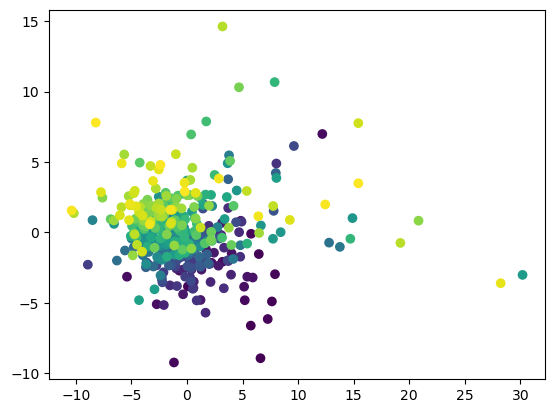

In [416]:
#transp = np.transpose(sorted_vis_window_zscore)
#print(transp.shape)

from sklearn.decomposition import PCA
pca = PCA()
z_pca = pca.fit_transform(sorted_vis_window_zscore)

print(z_pca.shape)

t = np.linspace(0, 1, z_pca.shape[0])
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=t)
plt.show()

[-1  0  1  2]


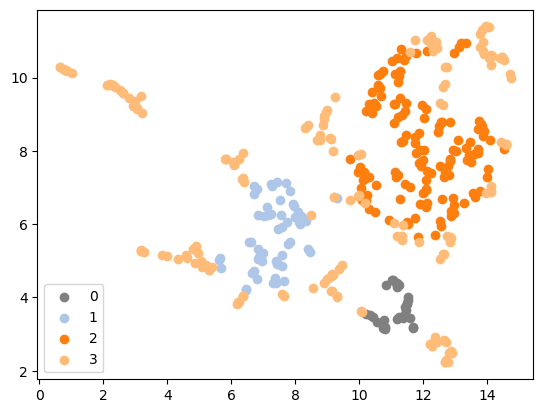

In [418]:
import umap
import hdbscan
import seaborn as sns

def do_umap(data):
    mapper = umap.UMAP(n_neighbors=3, min_dist=0.1)   # n_components= 4, init=z_pca[:, :4]
    z_umap = mapper.fit(data)
    z_umap = mapper.transform(data)

    clusterer = hdbscan.HDBSCAN(min_cluster_size=25)
    clusterer.fit(z_umap)
    cluster_values = np.unique(clusterer.labels_)
    print(cluster_values)

    cluster_values = np.unique(clusterer.labels_)
    cluster_list = [[] for value in cluster_values]
    for i, cell_value in enumerate(clusterer.labels_):
        cluster_list[cell_value].append(i)

    for i, cluster in enumerate(cluster_list):
        if i == 0:
            plt.scatter(z_umap[cluster, 0], z_umap[cluster, 1], color='gray', label=0)
        else:
            plt.scatter(z_umap[cluster, 0], z_umap[cluster, 1], color=sns.color_palette('tab20', 67)[i], label=i)

    plt.legend()
    plt.show()

    return cluster_list

cluster_list = do_umap(sorted_vis_window_zscore)

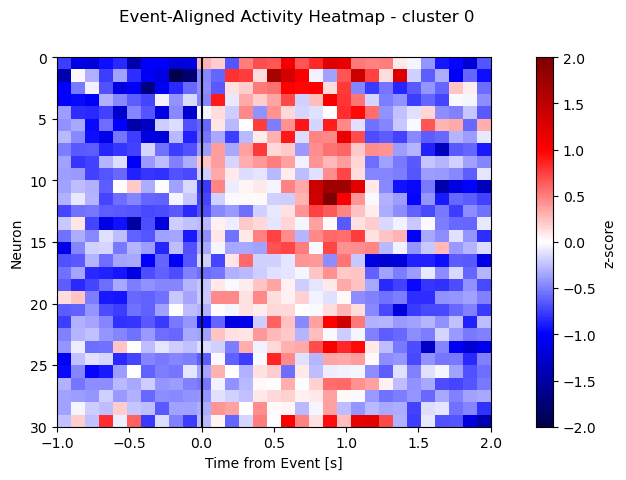

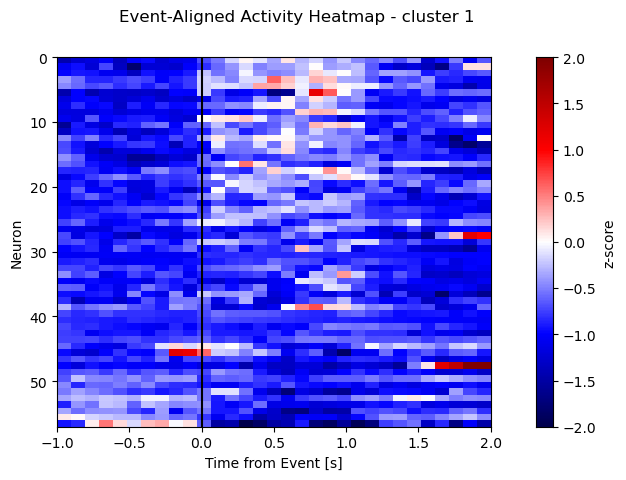

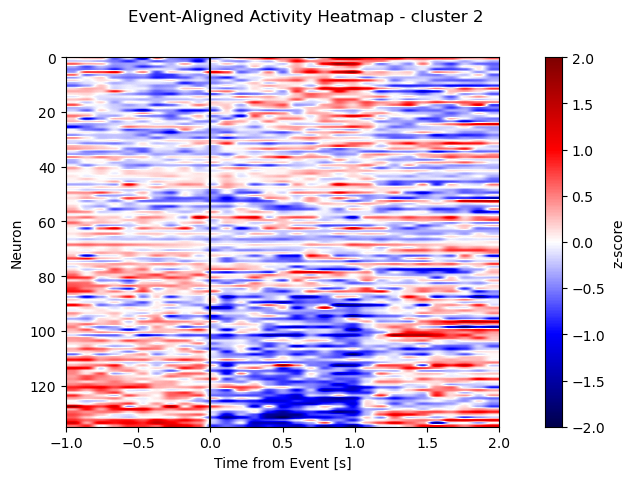

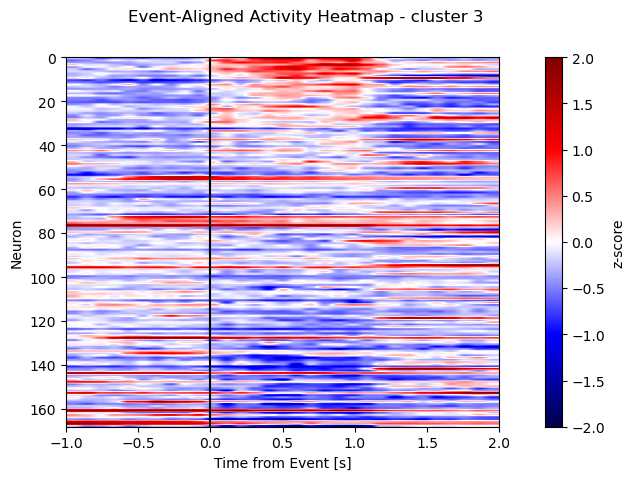

In [419]:
for i in range(len(cluster_list) if len(cluster_list) <= 10 else 10):
    clustered_zscore = [sorted_vis_window_zscore[cell] for cell in cluster_list[i]]
    scaled_zscores = scale_zscores(clustered_zscore)

    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [25, 1]})
    fig.suptitle(f"Event-Aligned Activity Heatmap - cluster {i}")

    plot_heatmap_and_gradient(axs, scaled_zscores, "seismic", np.vstack((np.linspace(1, 0, 256), np.linspace(1, 0, 256))), vis_window_timeline)

plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

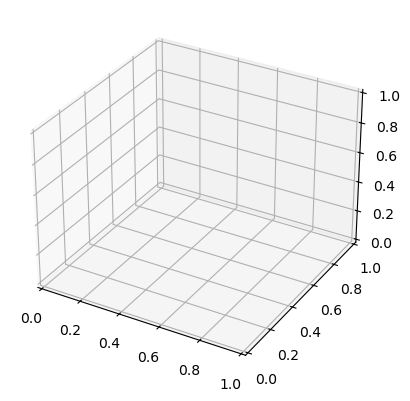

In [ ]:
%matplotlib inline
fig = plt.figure()
axe = plt.subplot(111, projection="3d")
axe.scatter(z_umap[:, 0], z_umap[:, 1], z_umap[:, 2], c=t)
plt.show()